<a href="https://www.kaggle.com/code/yogeshmodi04/sementic-segmentation-pcd?scriptVersionId=113105083" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [32]:
!pip install segmentation-models

In [33]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import segmentation_models as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input ,MaxPool2D, Concatenate,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [60]:
BACKBONE = 'resnet34'
pre_inputs = sm.get_preprocessing(BACKBONE)

In [61]:
csv_df = pd.read_csv('../input/pcd-train/train.csv')

In [62]:
csv_df['gleason_score'] = csv_df['gleason_score'].apply(lambda x: '0+0' if x == 'negative' else x)

In [63]:
ID = csv_df['image_id'] + '.png'
csv_df['image_id'] = ID
csv_df.head(10)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917.png,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d.png,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa.png,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9.png,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f.png,karolinska,0,0+0
5,002a4db09dad406c85505a00fb6f6144.png,karolinska,0,0+0
6,003046e27c8ead3e3db155780dc5498e.png,karolinska,1,3+3
7,0032bfa835ce0f43a92ae0bbab6871cb.png,karolinska,1,3+3
8,003a91841da04a5a31f808fb5c21538a.png,karolinska,1,3+3
9,003d4dd6bd61221ebc0bfb9350db333f.png,karolinska,1,3+3


In [64]:
csv_df['isup_grade'].value_counts()

0    2892
1    2666
2    1343
4    1249
3    1242
5    1224
Name: isup_grade, dtype: int64

In [65]:
csv_df['data_provider'].value_counts()

karolinska    5456
radboud       5160
Name: data_provider, dtype: int64

In [66]:
mask_labels = os.listdir('../input/panda2/train_label_masks')

In [67]:
df_mask = pd.Series(mask_labels).to_frame()
df_mask.columns = ['mask_id']
df_mask['image_id'] = df_mask.mask_id.apply(lambda x: x.split('_')[0])
df_train = pd.merge(csv_df, df_mask, on = 'image_id', how = 'outer')

In [68]:
xdf = df_train[df_train['image_id'] != df_train['mask_id']]

In [69]:
img_del = xdf['image_id'].values

In [70]:
a = list(img_del) 

In [71]:
len(a)

100

In [72]:
x = df_train[df_train['image_id'] != df_train['mask_id']].index

In [73]:
ndf = df_train.drop(x)

In [74]:
mapper = {'3+3':1,'0+0':0,'3+4':2,'4+3':3,'4+4':4,'negative':0,'4+5':5,'5+4':6,'5+5':7,'3+5':8,'5+3':9}
ndf['gleason_en'] = ndf.gleason_score.map(mapper)
ndf.head()

,image_id,data_provider,isup_grade,gleason_score,mask_id,gleason_en
0,0005f7aaab2800f6170c399693a96917.png,karolinska,0,0+0,0005f7aaab2800f6170c399693a96917.png,0
1,000920ad0b612851f8e01bcc880d9b3d.png,karolinska,0,0+0,000920ad0b612851f8e01bcc880d9b3d.png,0
2,0018ae58b01bdadc8e347995b69f99aa.png,radboud,4,4+4,0018ae58b01bdadc8e347995b69f99aa.png,4
3,001c62abd11fa4b57bf7a6c603a11bb9.png,karolinska,4,4+4,001c62abd11fa4b57bf7a6c603a11bb9.png,4
4,001d865e65ef5d2579c190a0e0350d8f.png,karolinska,0,0+0,001d865e65ef5d2579c190a0e0350d8f.png,0


In [75]:
y = ndf.drop(['image_id','data_provider','mask_id','gleason_score'], axis=1)
y = y.to_numpy()
y.shape

(10516, 2)

In [76]:
img_names = glob('/kaggle/input/panda2/train_images/*.png')
img_names.sort()
len(img_names)

10616

In [77]:
type(img_names)

list

In [119]:
# removing unwanted images if it display error list index out of range ran it once again.
for i in range(len(img_names)):
    for j in range(len(a)):
        if i <= len(img_names):
            if (img_names[i][-36:] == a[j]):
                x = img_names[i].index
                del img_names[i]
                i+=1
                

In [112]:
#length of list after removing
len(img_names)

10516

In [82]:
#sorting once again
img_names.sort()

In [83]:
#Capture training image info as a list
train_images = []
print(len(img_names))
for i in range(len(img_names)):
        img = cv2.imread(img_names[i],cv2.IMREAD_COLOR)
        img = cv2.resize(img,(128,128))
        img = img/255
        train_images.append(img)

10516


In [84]:
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [85]:
#shape after converting images into arrays
train_images.shape

(10516, 128, 128, 3)

In [86]:
msk_names = glob('/kaggle/input/panda2/train_label_masks/*.png')
msk_names.sort()

In [87]:
#Capture mask/label info as a list
train_masks = [] 
for i in range(len(msk_names)):
        mask = cv2.imread(msk_names[i],cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(128,128))
        mask = mask/255
        mask = np.expand_dims(mask, axis=-1)
        train_masks.append(mask)

In [88]:
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [89]:
train_masks.shape

(10516, 128, 128, 1)

In [90]:
train_images.sort()

In [91]:
train_masks.sort()

6789


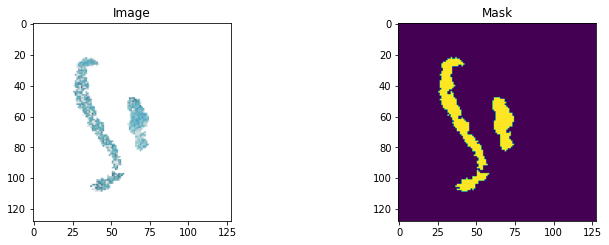

In [92]:
import random
img_number = random.randint(0, len(train_images)-1)
img = train_images[img_number]
mask = train_masks[img_number]
print(img_number)

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [93]:
x_train , x_val, y_train , y_val = train_test_split(train_images,train_masks, test_size = 0.2,random_state = 42)

In [94]:
print(len(x_train) , len(x_val), len(y_train) ,len( y_val))

8412 2104 8412 2104


In [95]:
x_train = pre_inputs(x_train)
x_val = pre_inputs(x_val)

In [96]:
model = sm.Unet(BACKBONE,encoder_weights = y.all())
model.compile(optimizer = 'adam', loss =sm.losses.bce_jaccard_loss, metrics = ['accuracy'] )

2022-12-06 12:26:37.083308: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [97]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [98]:
#early stoping
es = EarlyStopping(monitor='val_accuracy',min_delta=0.01, patience=3,verbose=1, mode='auto')
# check point
mc = ModelCheckpoint(monitor='val_accuracy', filepath="/kaggle/working/bestmodel.h5", verbose=1, save_best_only=True, mode= 'auto')

cd= [es,mc]

In [99]:
history = model.fit(x_train,y_train, batch_size =16, epochs= 10, verbose=1, validation_data=(x_val,y_val), callbacks= cd)

2022-12-06 12:26:39.449055: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
526/526 [==============================] - 1022s 2s/step - loss: 1.0416 - accuracy: 0.8732 - val_loss: 1.0036 - val_accuracy: 0.8859

Epoch 00001: val_accuracy improved from -inf to 0.88595, saving model to /kaggle/working/bestmodel.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
526/526 [==============================] - 1040s 2s/step - loss: 1.0006 - accuracy: 0.8789 - val_loss: 1.0012 - val_accuracy: 0.8859

Epoch 00002: val_accuracy improved from 0.88595 to 0.88595, saving model to /kaggle/working/bestmodel.h5
Epoch 3/10
526/526 [==============================] - 1027s 2s/step - loss: 0.9994 - accuracy: 0.8789 - val_loss: 1.0000 - val_accuracy: 0.8859

Epoch 00003: val_accuracy did not improve from 0.88595
Epoch 4/10
526/526 [==============================] - 1141s 2s/step - loss: 0.9991 - accuracy: 0.8789 - val_loss: 0.9992 - val_accuracy: 0.8859

Epoch 00004: val_accuracy did not improve from 0.88595
Epoch 00004: early stopping


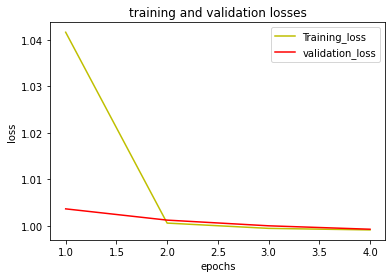

In [100]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs,loss, 'y', label = 'Training_loss')
plt.plot(epochs,val_loss, 'r', label = 'validation_loss')
plt.title('training and validation losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


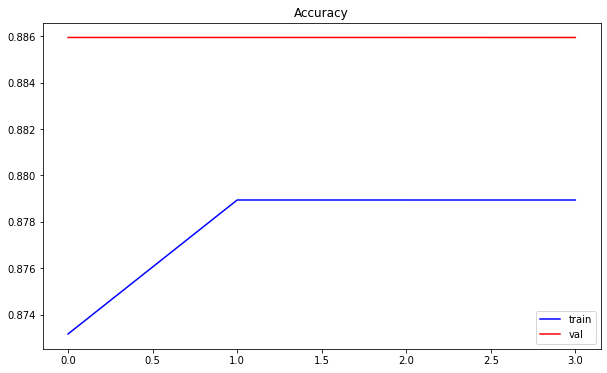

In [101]:
def plot_accuracy(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()
  
plot_accuracy(history)

In [102]:
#Capture training image info as a list
test_images = []
def read_img_test(x): 
        img = cv2.imread(x,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(128,128))
        img = img/255  # type: ignore
        test_images.append(img)

In [103]:
read_img_test('/kaggle/input/panda2/train_images/040847f885854a69d231c46196288d46.png')

In [104]:
test_images = np.array(test_images)

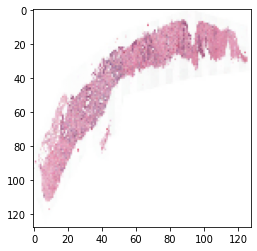

In [105]:
plt.imshow(test_images[0])

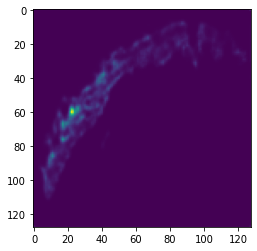

In [106]:
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/bestmodel.h5', compile=False)

prediction = model.predict(test_images)
#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image)
plt.show()